In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
import copy
import plotly.express as px

In [29]:
# 設置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [31]:
# 讀取數據
df = pd.read_csv("/content/0050.TW5.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/0050.TW5.csv'

In [13]:
# 預處理數據
timeseries = df[["Open", "High", "Low", "Close"]].values.astype('float32')

# 標準化數據
scaler = StandardScaler()
timeseries = scaler.fit_transform(timeseries)

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback, :]
        target = dataset[i+lookback]

        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4

# 將數據集分為訓練集和驗證集
train_size = int(len(timeseries) * 0.75)
train_data = timeseries[:train_size]
val_data = timeseries[train_size:]

X_train, y_train = create_dataset(train_data, lookback=lookback)
X_val, y_val = create_dataset(val_data, lookback=lookback)

input_size = timeseries.shape[-1]

# LSTM模型
class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=2048, num_layers=3, batch_first=True)
        self.linear = nn.Linear(2048, 4)  # 輸出四個特徵
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

# 設置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 將模型和數據移動到GPU
model = LSTM_Model().to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# 設置優化器和損失函數
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
n_epochs = 1000

# 訓練模型
for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=False, batch_size=2048):
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 計算訓練集和驗證集損失
    train_loss = np.mean(train_losses)
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_val_batch, y_val_batch in torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=2048):
            y_val_pred = model(X_val_batch)
            val_loss = loss_fn(y_val_pred, y_val_batch)
            val_losses.append(val_loss.item())
    val_loss = np.mean(val_losses)

    print(f"Epoch {epoch}: train_loss {train_loss:.4f}, val_loss {val_loss:.4f}")



Epoch 0: train_loss 1.1749, val_loss 0.5390
Epoch 1: train_loss 1.0231, val_loss 0.3609
Epoch 2: train_loss 0.2891, val_loss 0.0108
Epoch 3: train_loss 0.0156, val_loss 0.2975
Epoch 4: train_loss 0.2899, val_loss 0.1027
Epoch 5: train_loss 0.3953, val_loss 0.1050
Epoch 6: train_loss 0.1669, val_loss 0.0445
Epoch 7: train_loss 0.5161, val_loss 0.0642
Epoch 8: train_loss 0.0617, val_loss 0.0813
Epoch 9: train_loss 0.1697, val_loss 0.0553
Epoch 10: train_loss 0.1945, val_loss 0.0161
Epoch 11: train_loss 0.1196, val_loss 0.0774
Epoch 12: train_loss 0.1122, val_loss 0.1378
Epoch 13: train_loss 0.1328, val_loss 0.0494
Epoch 14: train_loss 0.0482, val_loss 0.0158
Epoch 15: train_loss 0.0197, val_loss 0.0416
Epoch 16: train_loss 0.0419, val_loss 0.0740
Epoch 17: train_loss 0.0677, val_loss 0.0887
Epoch 18: train_loss 0.0781, val_loss 0.0817
Epoch 19: train_loss 0.0724, val_loss 0.0590
Epoch 20: train_loss 0.0543, val_loss 0.0323
Epoch 21: train_loss 0.0328, val_loss 0.0168
Epoch 22: train_loss

預測的14天:
第1天: 開盤價=143.4922332763672, 最高價=143.93194580078125, 最低價=142.66648864746094, 收盤價=143.30235290527344
第2天: 開盤價=143.85902404785156, 最高價=144.28021240234375, 最低價=143.0631866455078, 收盤價=143.67967224121094
第3天: 開盤價=143.4211883544922, 最高價=143.86318969726562, 最低價=142.54705810546875, 收盤價=143.21778869628906
第4天: 開盤價=143.46852111816406, 最高價=143.90667724609375, 最低價=142.6346893310547, 收盤價=143.27708435058594
第5天: 開盤價=143.10943603515625, 最高價=143.56683349609375, 最低價=142.2346649169922, 收盤價=142.9085693359375
第6天: 開盤價=146.9228057861328, 最高價=147.20419311523438, 最低價=146.4667510986328, 收盤價=146.8445281982422
第7天: 開盤價=148.25294494628906, 最高價=148.490478515625, 最低價=147.58091735839844, 收盤價=148.07974243164062
第8天: 開盤價=148.15411376953125, 最高價=148.41845703125, 最低價=147.3223114013672, 收盤價=147.89039611816406
第9天: 開盤價=151.82716369628906, 最高價=151.95883178710938, 最低價=151.3353729248047, 收盤價=151.6339569091797
第10天: 開盤價=154.42396545410156, 最高價=154.48008728027344, 最低價=153.85137939453125, 收盤價=154.16421508789062
第11天: 開盤

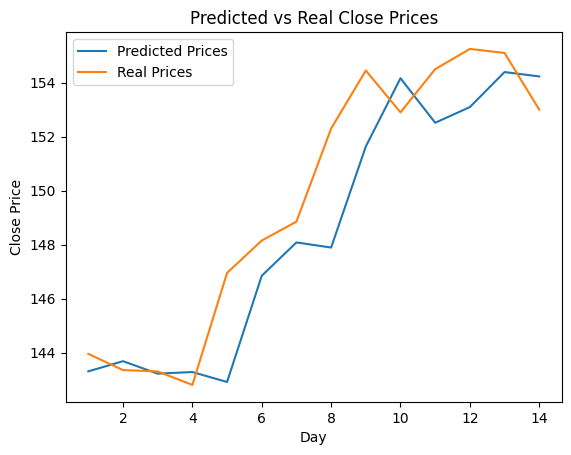

In [14]:
# 預測最後14天的數據
with torch.no_grad():  # 不計算梯度,用於推理
    model.eval()  # 將模型設置為評估模式
    # 取驗證集數據的倒數lookback+14天作為初始輸入
    input_data = torch.tensor(val_data[-(lookback+14):-14]).unsqueeze(0).to(device)

    # 儲存預測的14天和真實的14天
    predicted_14_days = []
    real_14_days = []

    for i in range(14):  # 預測14天
        # 使用當前的輸入數據預測下一天的特徵值
        next_day_prediction = model(input_data)
        # 將預測結果從張量轉換為numpy陣列，準備反標準化
        next_day_prediction_numpy = next_day_prediction.cpu().numpy()
        # 反標準化預測結果
        predicted_original = scaler.inverse_transform(next_day_prediction_numpy)
        predicted_14_days.append(predicted_original[0])  # 保存反標準化後的預測結果

        # 獲取真實的下一天數據
        real_next_day = val_data[-lookback-13+len(real_14_days)]
        real_next_day_original = scaler.inverse_transform([real_next_day])
        real_14_days.append(real_next_day_original[0])  # 保存反標準化後的真實數據

        # 為了繼續預測，我們需要將真實的下一天數據標準化後加入到輸入數據中
        next_input_data = torch.cat((input_data[:, 1:, :], torch.tensor(real_next_day).unsqueeze(0).unsqueeze(0).to(device)), dim=1)
        input_data = next_input_data

# 打印預測的14天和真實的14天（反標準化後的值）
print("預測的14天:")
predicted_prices = []
for day, prediction in enumerate(predicted_14_days, start=1):
    print(f"第{day}天: 開盤價={prediction[0]}, 最高價={prediction[1]}, 最低價={prediction[2]}, 收盤價={prediction[3]}")
    predicted_prices.append(prediction[3])  # 只保存收盤價

print("\n真實的14天:")
real_prices = []
for day, real in enumerate(real_14_days, start=1):
    print(f"第{day}天: 開盤價={real[0]}, 最高價={real[1]}, 最低價={real[2]}, 收盤價={real[3]}")
    real_prices.append(real[3])  # 只保存收盤價

# 繪製折線圖
days = range(1, 15)
plt.plot(days, predicted_prices, label='Predicted Prices')
plt.plot(days, real_prices, label='Real Prices')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Prices')
plt.legend()
plt.show()

预测的20天:
第1天: 开盘价=141.64930725097656, 最高价=142.1271209716797, 最低价=140.85415649414062, 收盘价=141.5034942626953
第2天: 开盘价=142.29110717773438, 最高价=142.73602294921875, 最低价=141.5299072265625, 收盘价=142.15782165527344
第3天: 开盘价=141.61825561523438, 最高价=142.0968780517578, 最低价=140.7257080078125, 收盘价=141.4430694580078
第4天: 开盘价=141.25196838378906, 最高价=141.75021362304688, 最低价=140.37388610839844, 收盘价=141.0783233642578
第5天: 开盘价=141.64930725097656, 最高价=142.1271209716797, 最低价=140.85415649414062, 收盘价=141.5034942626953
第6天: 开盘价=141.2744598388672, 最高价=141.76121520996094, 最低价=140.41566467285156, 收盘价=141.11166381835938
第7天: 开盘价=142.8671875, 最高价=143.28529357910156, 最低价=142.18463134765625, 收盘价=142.7594757080078
第8天: 开盘价=144.16429138183594, 最高价=144.5355682373047, 最低价=143.47825622558594, 收盘价=144.0471649169922
第9天: 开盘价=143.7755126953125, 最高价=144.17369079589844, 最低价=142.92869567871094, 收盘价=143.58804321289062
第10天: 开盘价=143.28457641601562, 最高价=143.72596740722656, 最低价=142.3865509033203, 收盘价=143.0707244873047
第11天: 开盘价=143.

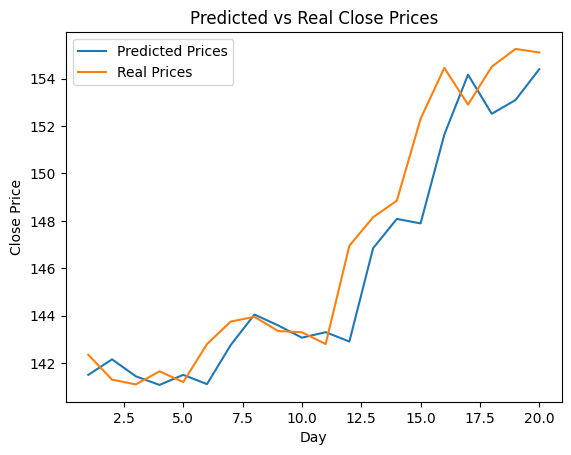

In [17]:
# 预测最后20天的数据
with torch.no_grad():  # 不计算梯度,用于推理
    model.eval()  # 将模型设置为评估模式
    # 取验证集数据的倒数lookback+20天作为初始输入
    input_data = torch.tensor(val_data[-(lookback+20):-20]).unsqueeze(0).to(device)

    # 储存预测的20天和真实的20天
    predicted_20_days = []
    real_20_days = []

    for i in range(20):  # 预测20天
        # 使用当前的输入数据预测下一天的特征值
        next_day_prediction = model(input_data)
        # 将预测结果从张量转换为numpy数组，准备反标准化
        next_day_prediction_numpy = next_day_prediction.cpu().numpy()
        # 反标准化预测结果
        predicted_original = scaler.inverse_transform(next_day_prediction_numpy)
        predicted_20_days.append(predicted_original[0])  # 保存反标准化后的预测结果

        # 获取真实的下一天数据
        real_next_day = val_data[-lookback-20+i]
        real_next_day_original = scaler.inverse_transform([real_next_day])
        real_20_days.append(real_next_day_original[0])  # 保存反标准化后的真实数据

        # 为了继续预测，我们需要将真实的下一天数据标准化后加入到输入数据中
        next_input_data = torch.cat((input_data[:, 1:, :], torch.tensor(real_next_day).unsqueeze(0).unsqueeze(0).to(device)), dim=1)
        input_data = next_input_data

# 打印预测的20天和真实的20天（反标准化后的值）
print("预测的20天:")
predicted_prices = []
for day, prediction in enumerate(predicted_20_days, start=1):
    print(f"第{day}天: 开盘价={prediction[0]}, 最高价={prediction[1]}, 最低价={prediction[2]}, 收盘价={prediction[3]}")
    predicted_prices.append(prediction[3])  # 只保存收盘价

print("\n真实的20天:")
real_prices = []
for day, real in enumerate(real_20_days, start=1):
    print(f"第{day}天: 开盘价={real[0]}, 最高价={real[1]}, 最低价={real[2]}, 收盘价={real[3]}")
    real_prices.append(real[3])  # 只保存收盘价

# 绘制折线图
days = range(1, 21)
plt.plot(days, predicted_prices, label='Predicted Prices')
plt.plot(days, real_prices, label='Real Prices')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Prices')
plt.legend()
plt.show()

In [27]:
# 假設lookback和scaler已經定義好了
# 假設模型已經訓練好了
with torch.no_grad():  # 不計算梯度,用於推理
    model.eval()  # 將模型設置為評估模式

    # 獲取最新的lookback天數據作為第一次預測的輸入
    input_data = torch.from_numpy(scaler.transform(df[['Open', 'High', 'Low', 'Close']].values[-lookback:]).astype(np.float32))
    input_data = input_data.unsqueeze(1).to(device)

    # 儲存未來7天的預測
    future_predictions = []

    for day in range(1, 8):  # 預測未來7天
        # 使用當前的輸入數據預測下一天的特徵值
        next_day_prediction = model(input_data)
        # 將預測結果從張量轉換為numpy陣列，準備反標準化
        next_day_prediction_numpy = next_day_prediction.cpu().numpy()
        # 反標準化預測結果
        future_predictions_original = scaler.inverse_transform(next_day_prediction_numpy)
        future_predictions.append(future_predictions_original[0])  # 保存反標準化後的預測結果

        # 為了繼續預測，我們需要將預測的結果標準化後加入到輸入數據中
        # 並去掉最前面的一天數據
        next_input_data = torch.cat((input_data[:, 1:, :], next_day_prediction.unsqueeze(1)), dim=1)
        input_data = next_input_data

# 打印未來7天的預測（反標準化後的值）
for day, prediction in enumerate(future_predictions, start=1):
    print(f"第{day}天: 開盤價={prediction[0]}, 最高價={prediction[1]}, 最低價={prediction[2]}, 收盤價={prediction[3]}")

第1天: 開盤價=150.31849670410156, 最高價=150.1604461669922, 最低價=152.45327758789062, 收盤價=151.61456298828125
第2天: 開盤價=148.9798583984375, 最高價=148.8647003173828, 最低價=151.03854370117188, 收盤價=150.253662109375
第3天: 開盤價=147.88198852539062, 最高價=147.8124542236328, 最低價=149.8640899658203, 收盤價=149.1372833251953
第4天: 開盤價=146.9674835205078, 最高價=146.9351348876953, 最低價=148.88558959960938, 收盤價=148.20655822753906
第5天: 開盤價=146.19662475585938, 最高價=146.195068359375, 最低價=148.06065368652344, 收盤價=147.4214630126953
第6天: 開盤價=145.54051208496094, 最高價=145.5647430419922, 最低價=147.35842895507812, 收盤價=146.75283813476562
第7天: 開盤價=144.9775390625, 最高價=145.02359008789062, 最低價=146.7558135986328, 收盤價=146.17884826660156
